<a href="https://colab.research.google.com/github/sidrakhan27/Air_noise/blob/main/Airplane_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.stats import mannwhitneyu
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier


In [3]:
data = pd.read_csv('/content/drive/MyDrive/noise_data_test.csv')
data

,Unnamed: 0,timestamp,max_slow,type,model
0,0,2022-03-01 00:03:47,70.800003,B738,Boeing 737-800
1,1,2022-03-01 00:05:02,69.199997,B738,Boeing 737-800
2,2,2022-03-01 00:06:24,69.599998,B738,Boeing 737-800
3,3,2022-03-01 00:09:47,71.500000,B738,Boeing 737-800
4,4,2022-03-01 00:11:43,70.800003,B738,Boeing 737-800
...,...,...,...,...,...
6668,6668,2022-05-28 22:56:30,66.000000,A148,Antonov An-148
6669,6669,2022-05-28 23:15:36,68.000000,B735,Boeing 737-500
6670,6670,2022-05-28 23:27:51,69.400002,SU95,Sukhoi Superjet 100-95
6671,6671,2022-05-28 23:40:33,66.500000,B738,Boeing 737-800


In [4]:
data.isnull().sum()

Unnamed: 0    0
timestamp     0
max_slow      0
type          0
model         0
dtype: int64

There are no missing data

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6673 entries, 0 to 6672
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6673 non-null   int64  
 1   timestamp   6673 non-null   object 
 2   max_slow    6673 non-null   float64
 3   type        6673 non-null   object 
 4   model       6673 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 260.8+ KB


In [6]:
data.shape

(6673, 5)

There are 6673 rows with 5 columns

In [7]:
data.describe()

,Unnamed: 0,max_slow
count,6673.000000,6673.000000
mean,3336.000000,68.477087
std,1926.473505,4.509026
min,0.000000,50.599998
25%,1668.000000,65.099998
50%,3336.000000,68.300003
75%,5004.000000,72.000000
max,6672.000000,91.500000


In [8]:
data['timestamp'] = pd.to_datetime(data['timestamp'])


In [9]:
data['Year'] = data['timestamp'].dt.year
data['Month'] = data['timestamp'].dt.month
data['Day'] = data['timestamp'].dt.day
data['DayofWeek'] = data['timestamp'].dt.dayofweek
data['Hour'] = data['timestamp'].dt.hour

In [10]:
data

,Unnamed: 0,timestamp,max_slow,type,model,Year,Month,Day,DayofWeek,Hour
0,0,2022-03-01 00:03:47,70.800003,B738,Boeing 737-800,2022,3,1,1,0
1,1,2022-03-01 00:05:02,69.199997,B738,Boeing 737-800,2022,3,1,1,0
2,2,2022-03-01 00:06:24,69.599998,B738,Boeing 737-800,2022,3,1,1,0
3,3,2022-03-01 00:09:47,71.500000,B738,Boeing 737-800,2022,3,1,1,0
4,4,2022-03-01 00:11:43,70.800003,B738,Boeing 737-800,2022,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
6668,6668,2022-05-28 22:56:30,66.000000,A148,Antonov An-148,2022,5,28,5,22
6669,6669,2022-05-28 23:15:36,68.000000,B735,Boeing 737-500,2022,5,28,5,23
6670,6670,2022-05-28 23:27:51,69.400002,SU95,Sukhoi Superjet 100-95,2022,5,28,5,23
6671,6671,2022-05-28 23:40:33,66.500000,B738,Boeing 737-800,2022,5,28,5,23


In [11]:
# drop unnecessary columns
data = data.drop(['Unnamed: 0', 'timestamp'], axis = 1)

In [12]:
data.type.nunique()

46

In [13]:
data.model.nunique()

46

In [14]:
def preprocess_airplace_data(data, target, cond_feature):
    summary_stats = data.groupby(cond_feature)[target].agg(['mean', 'median', 'var']).reset_index()
    summary_stats.rename(columns={'mean': 'arithmetic_mean', 'median': 'median', 'var': 'sample_variance'}, inplace = True)
    data = data.merge(summary_stats, on = cond_feature, how='left')
    data['Takeoff'] = np.where(data[target] >= data['median'], 1, 0)
    data.drop(['median', 'arithmetic_mean', 'sample_variance'], axis=1, inplace=True)
    return data


In [15]:
data = preprocess_airplace_data(data, 'max_slow', 'type')

In [16]:
data

,max_slow,type,model,Year,Month,Day,DayofWeek,Hour,Takeoff
0,70.800003,B738,Boeing 737-800,2022,3,1,1,0,1
1,69.199997,B738,Boeing 737-800,2022,3,1,1,0,0
2,69.599998,B738,Boeing 737-800,2022,3,1,1,0,0
3,71.500000,B738,Boeing 737-800,2022,3,1,1,0,1
4,70.800003,B738,Boeing 737-800,2022,3,1,1,0,1
...,...,...,...,...,...,...,...,...,...
6668,66.000000,A148,Antonov An-148,2022,5,28,5,22,1
6669,68.000000,B735,Boeing 737-500,2022,5,28,5,23,0
6670,69.400002,SU95,Sukhoi Superjet 100-95,2022,5,28,5,23,1
6671,66.500000,B738,Boeing 737-800,2022,5,28,5,23,0


Let's analyze

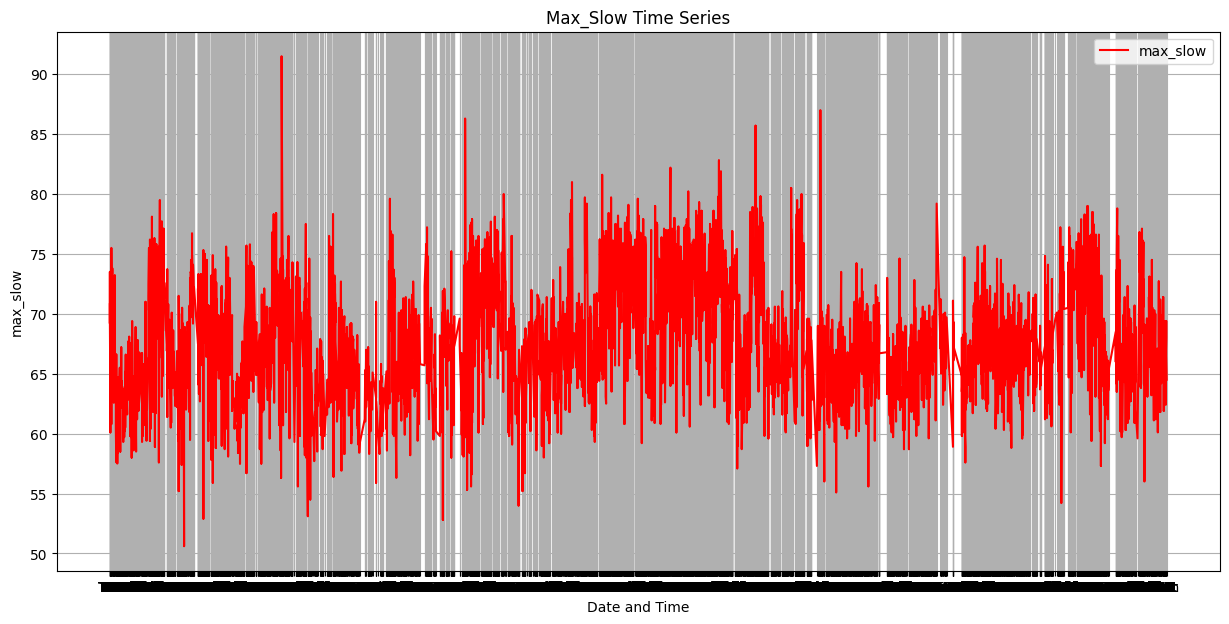

In [17]:
# Combine 'Year', 'Month', 'Day', 'Hour' columns into a single datetime column
data['Datetime'] = data.apply(lambda row: datetime(row['Year'], row['Month'], row['Day'], row['Hour']), axis=1)

# Create a time series plot with red lines
plt.figure(figsize=(15, 7))
plt.plot(data['Datetime'], data['max_slow'], color='red', label='max_slow')

# Add labels and title
plt.xlabel('Date and Time')
plt.ylabel('max_slow')
plt.title('Max_Slow Time Series')

# Show dayofweek on x-axis as text labels
dayofweek_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xticks(data['Datetime'], data['DayofWeek'].map(lambda d: dayofweek_labels[d]))

plt.legend()
plt.grid(True)
plt.show()

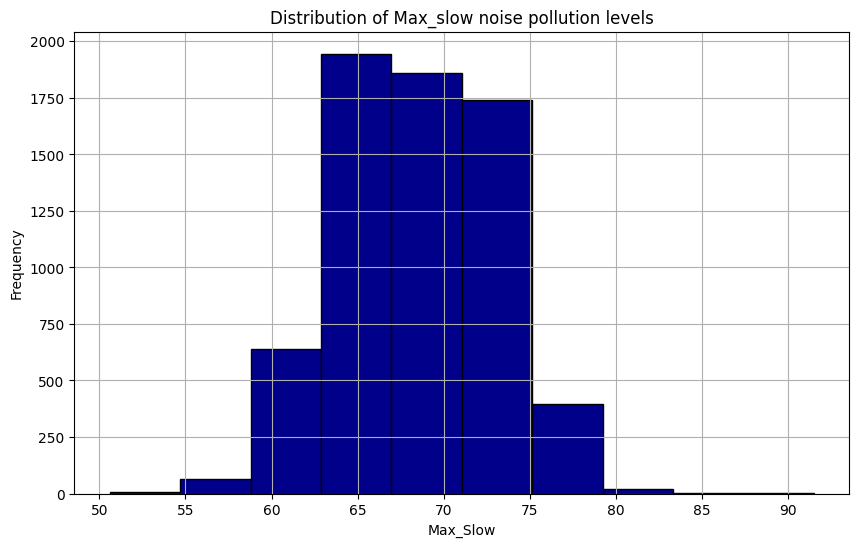

In [18]:
max_slow_value = data['max_slow']
plt.figure(figsize=(10,6))
plt.hist(max_slow_value, bins = 10, color= 'darkblue', edgecolor = 'black')

plt.xlabel('Max_Slow')
plt.ylabel('Frequency')
plt.title('Distribution of Max_slow noise pollution levels')
plt.grid(True)
plt.show()

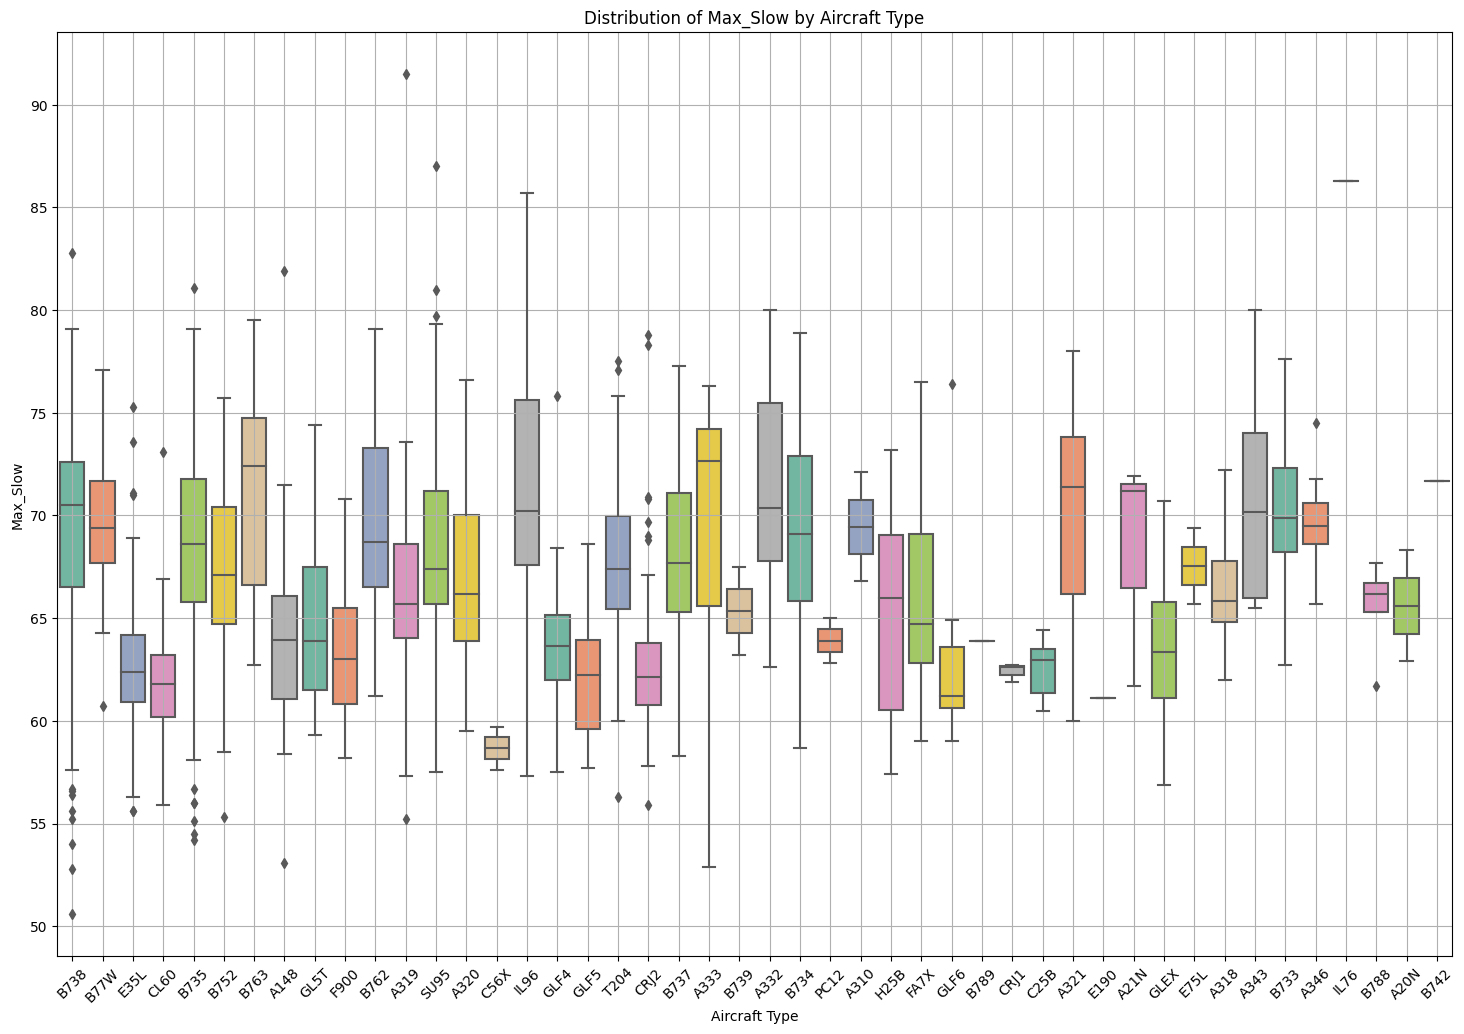

In [19]:
plt.figure(figsize=(18,12))
sns.boxplot(x = 'type', y = 'max_slow', data = data, palette='Set2')
plt.xlabel('Aircraft Type')
plt.ylabel('Max_Slow')
plt.title('Distribution of Max_Slow by Aircraft Type')
plt.xticks(rotation = 45)
plt.grid(True)
plt.show()

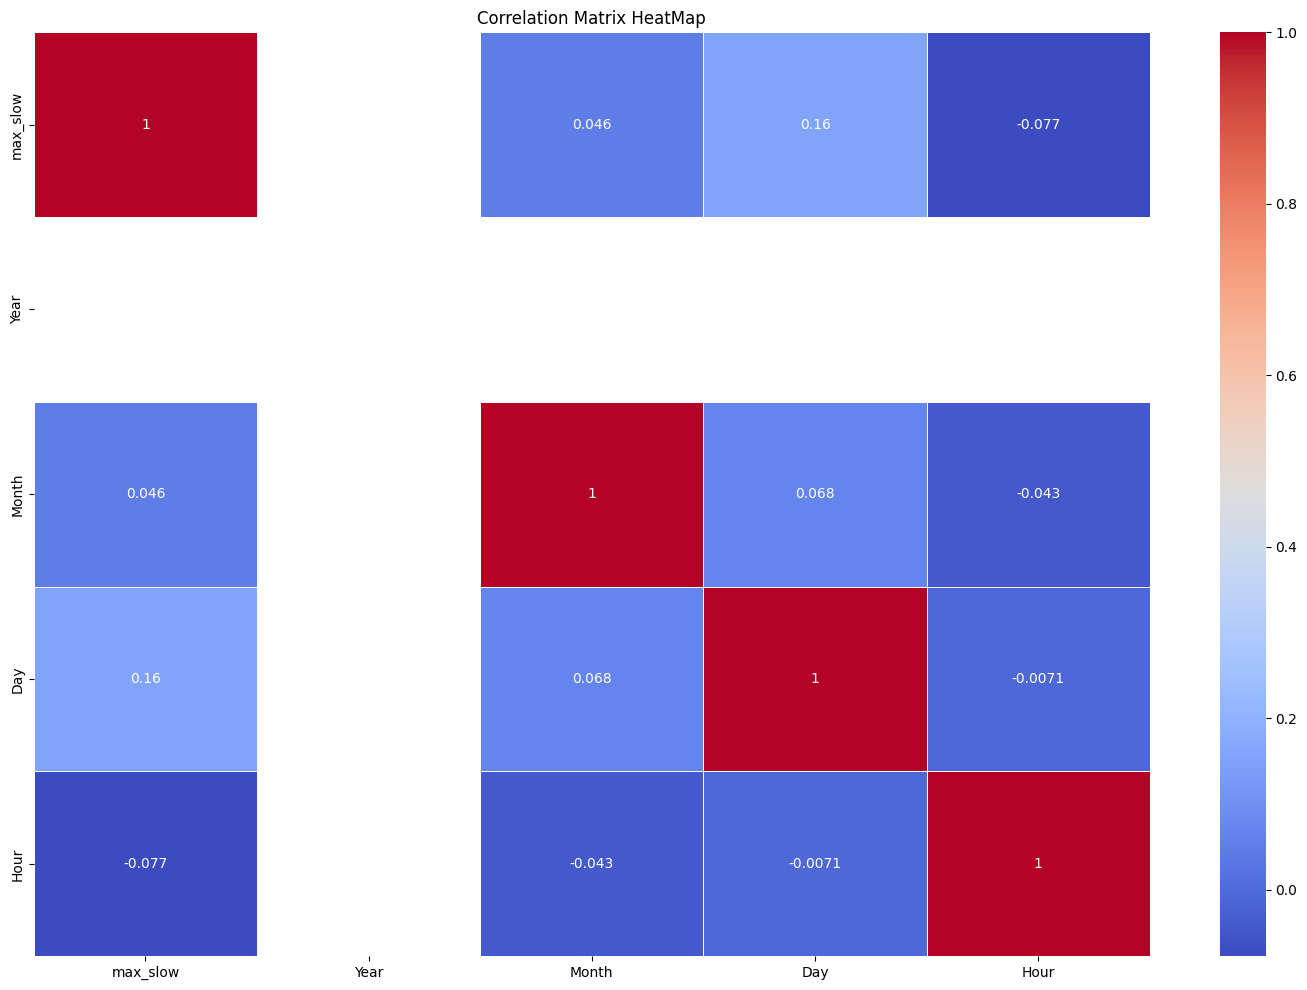

In [20]:
num_cols = ['max_slow', 'Year', 'Month', 'Day', 'Hour']
corr_matrix = data[num_cols].corr()
plt.figure(figsize=(18,12))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', linewidths=.5)
plt.title('Correlation Matrix HeatMap')
plt.show()

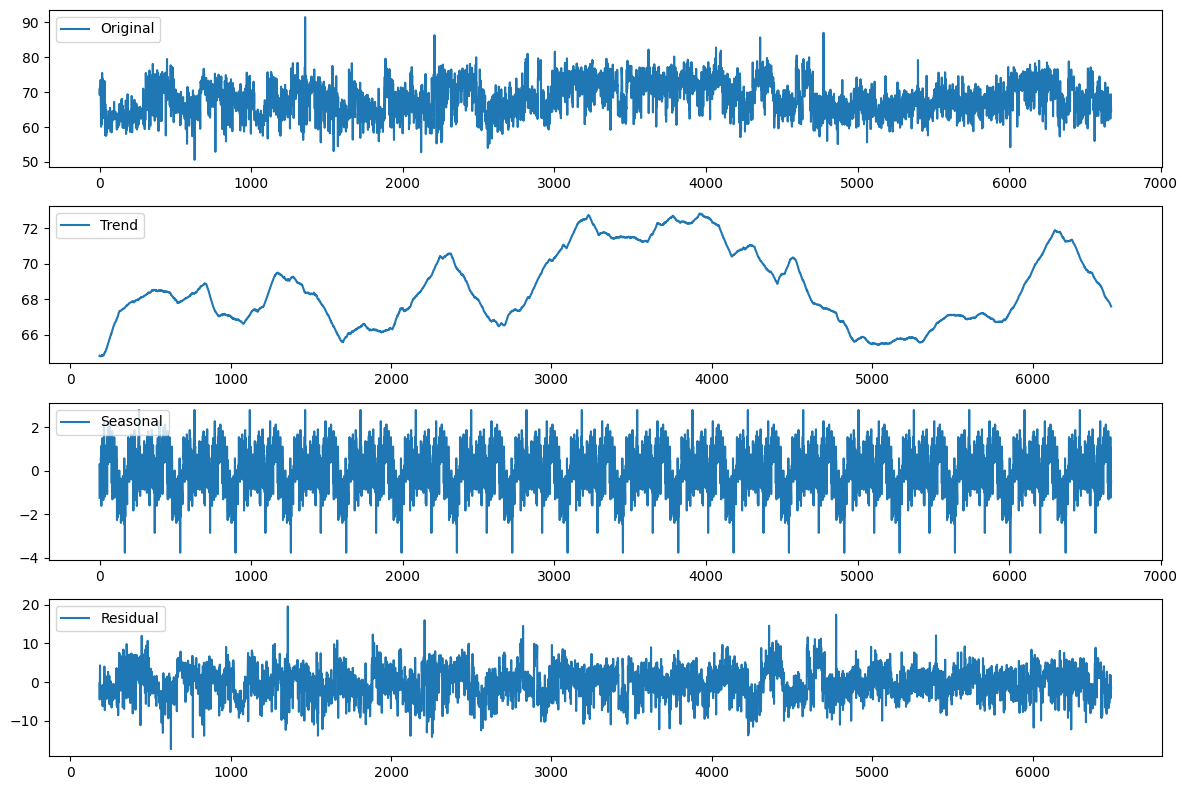

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['max_slow'], model = 'additive', period=365)
plt.figure(figsize=(12,8))
# Original time series
plt.subplot(411)
plt.plot(data['max_slow'], label='Original')
plt.legend(loc='upper left')

# Trend component
plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

# Seasonal component
plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

# Residual component
plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')
# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [22]:
data

,max_slow,type,model,Year,Month,Day,DayofWeek,Hour,Takeoff,Datetime
0,70.800003,B738,Boeing 737-800,2022,3,1,1,0,1,2022-03-01 00:00:00
1,69.199997,B738,Boeing 737-800,2022,3,1,1,0,0,2022-03-01 00:00:00
2,69.599998,B738,Boeing 737-800,2022,3,1,1,0,0,2022-03-01 00:00:00
3,71.500000,B738,Boeing 737-800,2022,3,1,1,0,1,2022-03-01 00:00:00
4,70.800003,B738,Boeing 737-800,2022,3,1,1,0,1,2022-03-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...
6668,66.000000,A148,Antonov An-148,2022,5,28,5,22,1,2022-05-28 22:00:00
6669,68.000000,B735,Boeing 737-500,2022,5,28,5,23,0,2022-05-28 23:00:00
6670,69.400002,SU95,Sukhoi Superjet 100-95,2022,5,28,5,23,1,2022-05-28 23:00:00
6671,66.500000,B738,Boeing 737-800,2022,5,28,5,23,0,2022-05-28 23:00:00


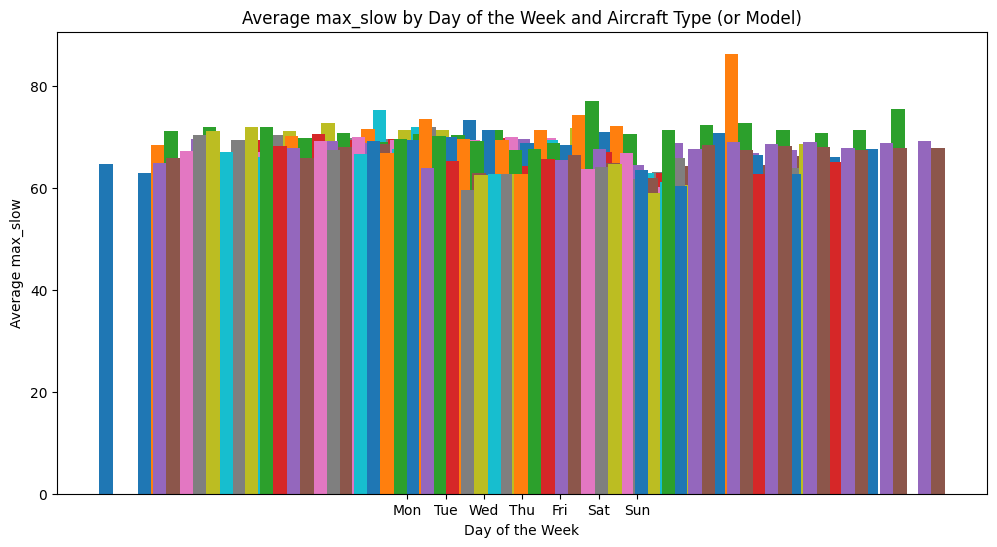

In [23]:
# Group the data by 'DayofWeek' and 'type' (or 'model') and calculate the mean max_slow for each group
grouped_data = data.groupby(['DayofWeek', 'type'])['max_slow'].mean().unstack()

# Define the days of the week for the x-axis
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Define the width of each bar
bar_width = 0.35
index = range(len(days_of_week))

# Loop through each aircraft type (or model) and plot a bar for each day of the week
for i, aircraft_type in enumerate(grouped_data.columns):
    plt.bar([x + bar_width * i for x in index], grouped_data[aircraft_type], width=bar_width, label=aircraft_type)

# Customize the plot
plt.xlabel('Day of the Week')
plt.ylabel('Average max_slow')
plt.title('Average max_slow by Day of the Week and Aircraft Type (or Model)')
plt.xticks([x + bar_width * (len(grouped_data.columns) - 1) / 2 for x in index], days_of_week)

# Show the plot
plt.show()

In [24]:
data.shape[0]

6673

In [25]:
data.shape[1]

10

In [26]:
group_data = data.groupby('type').mean()[['max_slow']]

<ipython-input-26-93bcc4b8d54a>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  group_data = data.groupby('type').mean()[['max_slow']]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

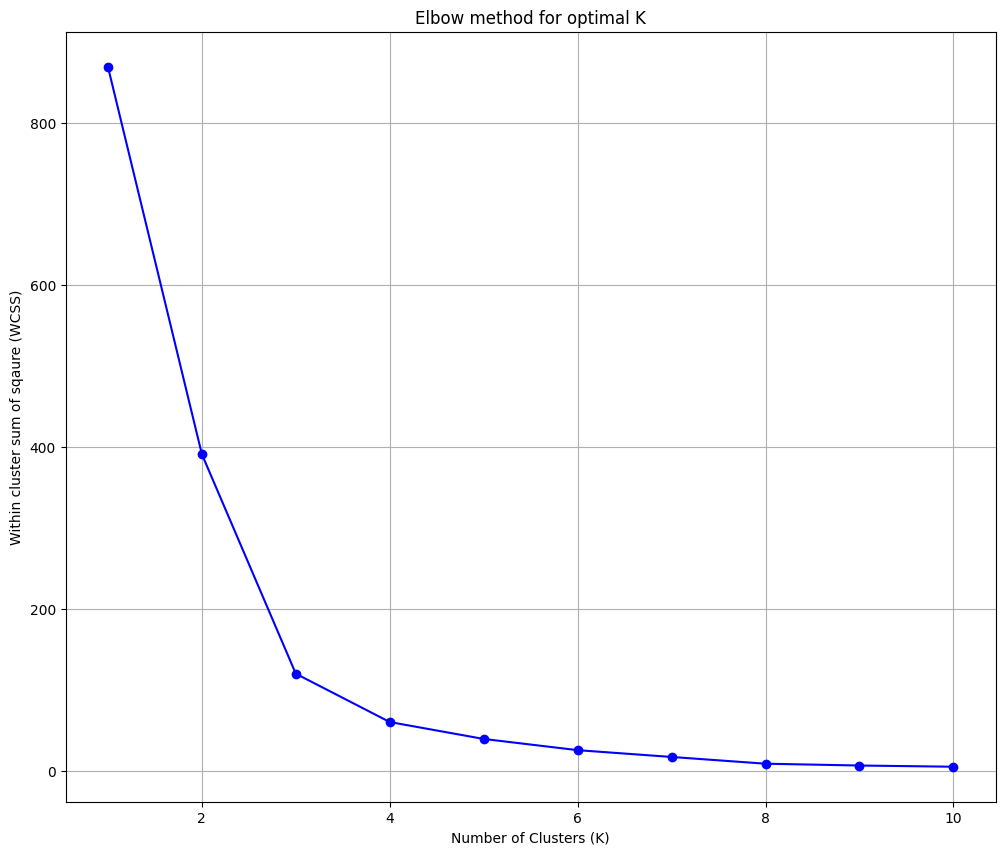

In [27]:
wcss = []

for i in range(1,11):
    km = KMeans(n_clusters=i)
    km.fit(group_data)
    wcss.append(km.inertia_)

plt.figure(figsize=(12, 10))
plt.plot(range(1,11), wcss, marker='o', linestyle='-', color = 'b')
plt.title('Elbow method for optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within cluster sum of sqaure (WCSS)')
plt.grid()
plt.show()



In [28]:
group_data

,max_slow
type,
A148,64.047500
A20N,65.600002
A21N,68.266666
A310,69.450001
A318,66.206250
A319,66.286325
A320,67.010660
A321,70.120305
A332,71.274193


In [29]:
kmean = KMeans(n_clusters=4, random_state=0)
pred=kmean.fit_predict(group_data)
group_data['class']=pred
group_data=group_data.reset_index().drop('max_slow',axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [30]:
df = data.merge(group_data, on=['type'], how='left')
df.head()

,max_slow,type,model,Year,Month,Day,DayofWeek,Hour,Takeoff,Datetime,class
0,70.800003,B738,Boeing 737-800,2022,3,1,1,0,1,2022-03-01,1
1,69.199997,B738,Boeing 737-800,2022,3,1,1,0,0,2022-03-01,1
2,69.599998,B738,Boeing 737-800,2022,3,1,1,0,0,2022-03-01,1
3,71.500000,B738,Boeing 737-800,2022,3,1,1,0,1,2022-03-01,1
4,70.800003,B738,Boeing 737-800,2022,3,1,1,0,1,2022-03-01,1


In [31]:
df.columns

Index(['max_slow', 'type', 'model', 'Year', 'Month', 'Day', 'DayofWeek',
       'Hour', 'Takeoff', 'Datetime', 'class'],
      dtype='object')

In [32]:
df.drop(['type', 'model', 'Year'], axis=1, inplace = True)

In [33]:
df

,max_slow,Month,Day,DayofWeek,Hour,Takeoff,Datetime,class
0,70.800003,3,1,1,0,1,2022-03-01 00:00:00,1
1,69.199997,3,1,1,0,0,2022-03-01 00:00:00,1
2,69.599998,3,1,1,0,0,2022-03-01 00:00:00,1
3,71.500000,3,1,1,0,1,2022-03-01 00:00:00,1
4,70.800003,3,1,1,0,1,2022-03-01 00:00:00,1
...,...,...,...,...,...,...,...,...
6668,66.000000,5,28,5,22,1,2022-05-28 22:00:00,3
6669,68.000000,5,28,5,23,0,2022-05-28 23:00:00,1
6670,69.400002,5,28,5,23,1,2022-05-28 23:00:00,1
6671,66.500000,5,28,5,23,0,2022-05-28 23:00:00,1


In [34]:
Class = pd.get_dummies(df['class'], prefix = 'Airplane_Class')
df = pd.concat([df, Class], axis = 1)
df = df.drop(['class', 'Datetime'], axis = 1)

In [35]:
df

,max_slow,Month,Day,DayofWeek,Hour,Takeoff,Airplane_Class_0,Airplane_Class_1,Airplane_Class_2,Airplane_Class_3
0,70.800003,3,1,1,0,1,0,1,0,0
1,69.199997,3,1,1,0,0,0,1,0,0
2,69.599998,3,1,1,0,0,0,1,0,0
3,71.500000,3,1,1,0,1,0,1,0,0
4,70.800003,3,1,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
6668,66.000000,5,28,5,22,1,0,0,0,1
6669,68.000000,5,28,5,23,0,0,1,0,0
6670,69.400002,5,28,5,23,1,0,1,0,0
6671,66.500000,5,28,5,23,0,0,1,0,0


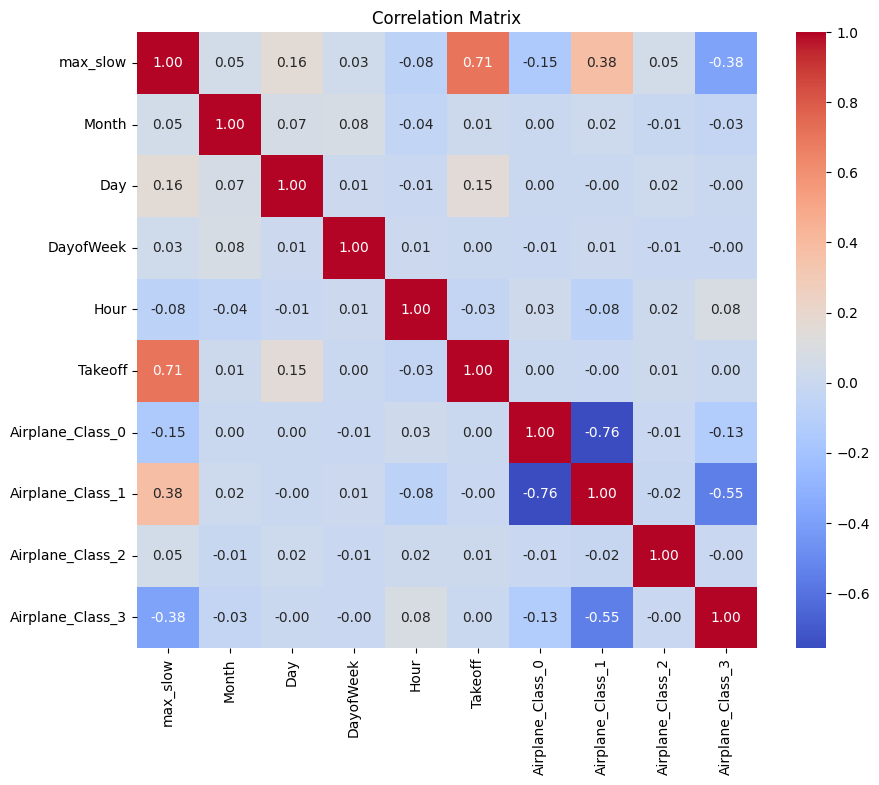

In [36]:
correlation_matrix = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [37]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [38]:
X = df.drop(['max_slow'], axis=1)
y = df['max_slow']


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [40]:
df.max_slow.min(), df.max_slow.max()

(50.59999847412109, 91.5)

(array([  1.,   2.,  37.,  80., 212., 196., 200., 171.,  79.,  22.]),
 array([52.79999924, 55.46999931, 58.13999939, 60.80999947, 63.47999954,
        66.14999962, 68.81999969, 71.48999977, 74.15999985, 76.82999992,
        79.5       ]),
 <BarContainer object of 10 artists>)

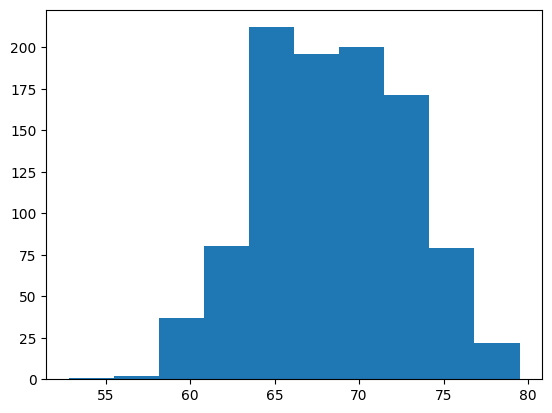

In [41]:
plt.hist(df.max_slow.sample(1000))

In [42]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.5 MB/s eta 0:00:00


In [43]:
import optuna
import xgboost as xgb


In [44]:
study = optuna.create_study(direction='minimize')


[I 2023-09-29 20:54:19,563] A new study created in memory with name: no-name-fee12ae2-4ac0-47a9-ba4b-fa431b566873


In [50]:
def objective(trial, data, target):
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.1, random_state=42)

    param = {
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13, 15, 17]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)

    model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=100, verbose=False)

    preds = model.predict(test_x)

    mse = mean_squared_error(test_y, preds)

    return mse


In [51]:
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X, y), n_trials=100)

# Print the best trial parameters and best value (MSE)
print("Best trial: ", study.best_trial.params)
print("Best value (MSE): ", study.best_value)


[I 2023-09-29 21:01:32,924] A new study created in memory with name: no-name-8ffe625a-aa39-48a8-996c-bd8478899855
[I 2023-09-29 21:01:37,349] Trial 0 finished with value: 5.0438437631254756 and parameters: {'lambda': 0.016812525740977236, 'alpha': 0.014537055950609331, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.016, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 18}. Best is trial 0 with value: 5.0438437631254756.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2023-09-29 21:01:50,349] Trial 1 finished with value: 5.225222649221132 and parameters: {'lambda': 0.050818184901668534, 'alpha': 4.232665893059182, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 249}. Best is t

Best trial:  {'lambda': 0.5855094047380744, 'alpha': 0.01680167504771933, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 8}
Best value (MSE):  4.688680567020031


The best achieved MSE on your validation dataset is approximately 4.69 using these hyperparameters

In [52]:
from optuna import visualization
print('Best trial: MSE= {},\nparams {}'.format(study.best_trial.value,study.best_trial.params))
hist = study.trials_dataframe()
hist.head()

Best trial: MSE= 4.688680567020031,
params {'lambda': 0.5855094047380744, 'alpha': 0.01680167504771933, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 8}


,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_lambda,params_learning_rate,params_max_depth,params_min_child_weight,params_random_state,params_subsample,state
0,0,5.043844,2023-09-29 21:01:32.926659,2023-09-29 21:01:37.349186,0 days 00:00:04.422527,0.014537,0.4,0.016813,0.016,5,18,2020,0.8,COMPLETE
1,1,5.225223,2023-09-29 21:01:37.353090,2023-09-29 21:01:50.349573,0 days 00:00:12.996483,4.232666,0.4,0.050818,0.008,11,249,2020,1.0,COMPLETE
2,2,5.129421,2023-09-29 21:01:50.352108,2023-09-29 21:01:59.101112,0 days 00:00:08.749004,0.164529,0.6,0.002464,0.016,13,147,2020,0.6,COMPLETE
3,3,5.255917,2023-09-29 21:01:59.102882,2023-09-29 21:02:14.135284,0 days 00:00:15.032402,0.021868,0.7,0.002911,0.008,7,288,2020,0.7,COMPLETE
4,4,5.846232,2023-09-29 21:02:14.137104,2023-09-29 21:02:17.411546,0 days 00:00:03.274442,5.084597,0.3,0.003779,0.020,15,264,2020,0.4,COMPLETE


In [53]:
optuna.visualization.plot_slice(study)


In [54]:
optuna.visualization.plot_param_importances(study)


In [55]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 30

we can quickly solve the inverse problem of determining the flight mode without finding the optimal hyperparameters of the model.

In [58]:
x=df.drop(['Takeoff'],axis=1)
Y=df['Takeoff']
x_train, x_test, Y_train, Y_test=train_test_split(x,Y,test_size=0.2,random_state=42)

In [68]:
# Create a list of classification models
models = [KNeighborsClassifier(), LogisticRegression(), XGBClassifier(), ExtraTreesClassifier(), RandomForestClassifier()]

# Create a dictionary to store model performance scores
scores = dict()

# Iterate through each model and evaluate its performance
for model in models:
    model.fit(x_train, Y_train)  # Train the model
    y_pred = model.predict(x_test)  # Make predictions on the test data

    # Calculate evaluation metrics
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred)
    recall = recall_score(Y_test, y_pred)
    f1 = f1_score(Y_test, y_pred)

    # Store the scores in the dictionary
    scores[str(model)] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [69]:
# Print the model performance scores
for model_name, score in scores.items():
    print(f'Model: {model_name}')
    for metric, value in score.items():
        print(f'{metric}: {value}')
    print('-' * 30)

Model: KNeighborsClassifier()
Accuracy: 0.8606741573033708
Precision: 0.9025974025974026
Recall: 0.8152492668621701
F1-Score: 0.8567026194144838
------------------------------
Model: LogisticRegression()
Accuracy: 0.9078651685393259
Precision: 0.912850812407681
Recall: 0.906158357771261
F1-Score: 0.9094922737306843
------------------------------
Model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_

Interpretation of Results:

Model Performance: The XGBClassifier demonstrated the highest overall performance across all evaluation metrics, with an accuracy of 0.920 and an F1-Score of 0.921. This indicates that it is the most accurate and well-balanced model among those tested.

Precision and Recall: Model 2 (LogisticRegression) showed a strong balance between precision (0.913) and recall (0.906), which is important for our problem as it minimizes both false positives and false negatives.

Trade-offs: It's important to consider the trade-offs between different metrics. For instance, Model 4 (ExtraTreesClassifier) achieved a high precision (0.928) but at the cost of slightly lower recall (0.891). This trade-off should be evaluated in the context of the specific application.

Further Analysis: Additional analysis, such as feature importance and model interpretability, should be conducted to understand the factors driving model predictions and identify potential areas for improvement.

Model Selection: Depending on the specific objectives and constraints of the project, the choice of the best model may vary. The XGBClassifier is recommended for its overall strong performance, but the final decision should consider other factors like computational resources and business requirements.